<a href="https://colab.research.google.com/github/shani1610/defects-detection/blob/main/notebooks/deep_learning_feature_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Matching for Defect Detection

this notebook is written to provide a method for feature matching,
using LoFTR, a dtector-free transformer based model.

In [1]:
import os
current_path = os.getcwd()
print(current_path)

/content


## Load the repository that contain the images to match

In [3]:
# Clone the Repo
!git clone https://github.com/shani1610/defects-detection.git

Cloning into 'defects-detection'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 78 (delta 12), reused 73 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 8.40 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [5]:
%cd defects-detection

/content/defects-detection


In [6]:
!pip install -r requirements.txt

# LoFTR


In [7]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
#!mv LoFTR/* . && rm -rf LoFTR

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [8]:
# Download pretrained weights
%cd LoFTR
!mkdir weights
%cd weights/
#!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ../..

/content/defects-detection/LoFTR
/content/defects-detection/LoFTR/weights
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY
From (redirected): https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY&confirm=t&uuid=66edea59-6d74-41f3-87bd-ecb37f578a65
To: /content/defects-detection/LoFTR/weights/outdoor_ds.ckpt
100% 46.3M/46.3M [00:00<00:00, 50.6MB/s]
/content/defects-detection


In [9]:
%cd LoFTR

import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
image_type = 'outdoor'
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

%cd ..

/content/defects-detection/LoFTR


<ipython-input-9-41247317ef8f>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])


/content/defects-detection


In [10]:
os.getcwd()


'/content/defects-detection'

In [11]:
def run_loftr(img0_raw, img1_raw):
  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()
  # Draw
  color = cm.jet(mconf, alpha=0.7)

  fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text='')

  # A high-res PDF will also be downloaded automatically.
  make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text='', path="LoFTR-colab-demo.pdf")
  # files.download("LoFTR-colab-demo.pdf")
  return mkpts0, mkpts1, mconf




# Match the images

In [14]:
os.getcwd()


'/content/defects-detection'

In [15]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "./data/defective/case1_inspected_image.tif"
img1_pth = "./data/defective/case1_reference_image.tif"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

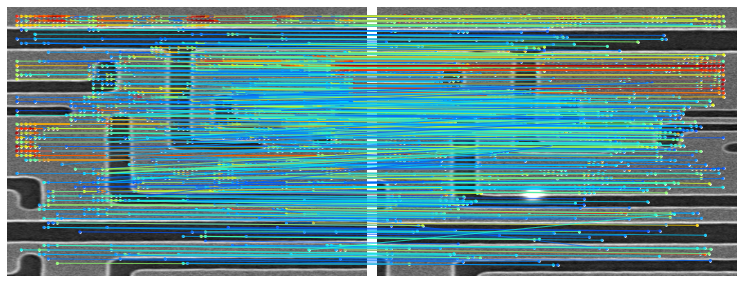

In [16]:
mkpts0, mkpts1, mconf = run_loftr(img0_raw, img1_raw)